In [1]:
from collections import OrderedDict
import torch
import numpy as np
import matplotlib.pyplot as plt
from curves import CurveNet
import sklearn
import pickle

In [2]:
def ckpt_to_models(path, name='checkpoint-100.pt'):
    state = OrderedDict(sorted(torch.load(f'checkpoint/mnist/{path}/{name}')['model_state'].items()))
    n = int(state['coeff_layer.range'].max().item() + 1)
    params = [[] for _ in range(n)]
    for i, p in enumerate(list(state.values())[1:]):
        params[i % n].append(p.cpu().flatten())
    params = [torch.cat([p[1], p[0], p[3], p[2], p[5], p[4]], axis=0) for p in params]
    out = []
    for i in range(n):
        out.append(torch.cat(params[i::n]).numpy())
    return out

def load_neb(path):
    with open(f'neb/{path}.pkl', 'rb') as file:
        curve = pickle.load(file)
    return curve['path_coords'].numpy()

def get_draxler(i):
    with open(f'neb/graph{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    edge = data.get_edge_data(1,2,4)
    path = edge['path_coords']
    return path.numpy()

In [3]:
paths_garipov = np.array([ckpt_to_models(p) for p in ['path1', 'path2', 'path3', 'path4']])
paths_draxler = [get_draxler(i) for i in range(6)]

In [4]:
n_paths, n_points, n_params = paths_garipov.shape
n_paths_d = len(paths_draxler)

In [5]:
def prepare_for_pca(garipov, draxler):

    return np.concatenate([[garipov[0,0,:]], # Start point
                           [garipov[0,-1,:]], # End point
                           garipov[:,1:-1,:].reshape(-1,n_params),
                           np.concatenate([d[1:-1,:] for d in draxler],axis=0)],
                          axis=0)


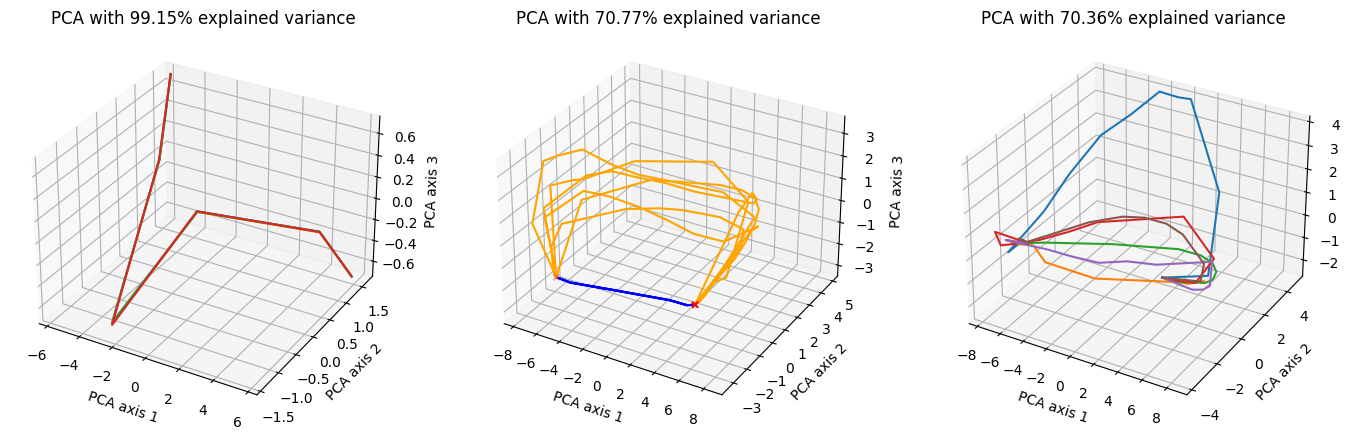

In [6]:
from sklearn.decomposition import PCA

pca_both = PCA(n_components=3)
pca_all = pca_both.fit_transform(X=prepare_for_pca(paths_garipov, paths_draxler))
pca_g = PCA(n_components=3)
pca_g.fit(X=np.concatenate([[paths_garipov[0,0,:]],
                            [paths_garipov[0,-1,:]],
                            paths_garipov[:,1:-1,:].reshape(-1,n_params)],
                           axis=0))
pca_d = PCA(n_components=3)
pca_d.fit(X=np.concatenate([[paths_garipov[0,0,:]],
                            [paths_garipov[0,-1,:]],
                            np.concatenate([d[1:-1,:] for d in paths_draxler], axis=0)],
                           axis=0))

fig = plt.figure(figsize=(17,6))
ax=[fig.add_subplot(131, projection='3d'),
    fig.add_subplot(132, projection='3d'),
    fig.add_subplot(133, projection='3d'),
    ]

def plot_me(n, arr, ax, pca, **kwargs):
    for i in range(n):
        transformed = pca.transform(arr[i])
        ax.plot3D(transformed[:,0], transformed[:,1], transformed[:,2], **kwargs)
        ax.set_title(f'PCA with {100*pca.explained_variance_ratio_.sum():.2f}% explained variance')

plot_me(n_paths, paths_garipov, ax[0], pca_g)
plot_me(n_paths, paths_garipov, ax[1], pca_both, color='blue')
plot_me(n_paths_d, paths_draxler, ax[1], pca_both, color='orange')
plot_me(n_paths_d, paths_draxler, ax[2], pca_d)

ax[1].scatter3D(pca_all[[0,1],0],pca_all[[0,1],1],pca_all[[0,1],2],color='red',marker='x')  # Endpoints in red
for axis in ax:
    axis.set_xlabel('PCA axis 1')
    axis.set_ylabel('PCA axis 2')
    axis.set_zlabel('PCA axis 3')
fig.savefig('gvp.png', dpi=300)
pass

In [7]:
with open('neb/barrier.pkl', 'rb') as file:
    barrier = pickle.load(file)
with open('neb/interpolated.pkl', 'rb') as file:
    interpolated = pickle.load(file)
with open('neb/draxlers.pkl', 'rb') as file:
    draxlers = pickle.load(file)
with open('neb/total.pkl', 'rb') as file:
    total = pickle.load(file)
garipov = np.load('checkpoints_new/curve.npz')['te_nll']

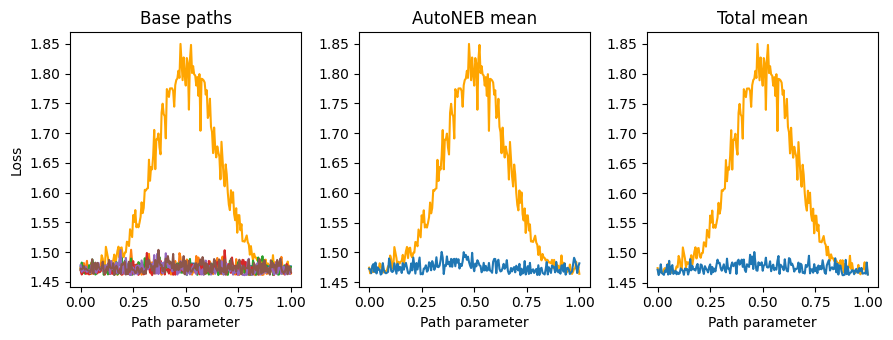

In [8]:
fig = plt.figure(figsize=(9,3.5))
ax=[fig.add_subplot(131),
    fig.add_subplot(132),
    fig.add_subplot(133),
    ]

xs = np.linspace(0,1,201)
ax[0].plot(xs, barrier, color='orange')
ax[1].plot(xs, barrier, color='orange')
ax[2].plot(xs, barrier, color='orange')

ax[0].plot(np.linspace(0,1,61), garipov)
for i in range(draxlers.shape[0]):
    ax[0].plot(xs, draxlers[i,:])
ax[1].plot(xs, interpolated)
ax[2].plot(xs, total)

for i in range(3):
    ax[i].set_xlabel('Path parameter')
ax[0].set_ylabel('Loss')

ax[0].set_title('Base paths')
ax[1].set_title('AutoNEB mean')
ax[2].set_title('Total mean')

fig.tight_layout()

fig.savefig('losses.png', dpi=300)

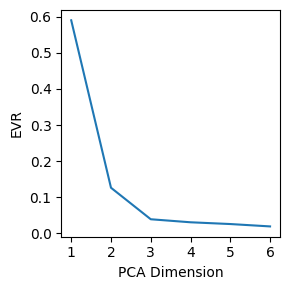

In [42]:
points = np.load('oversampled.npz')['X']
pca = PCA(n_components=6)
pca.fit(X=points)

fig = plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.plot(1+np.arange(6), pca.explained_variance_ratio_)
ax.set_xlabel('PCA Dimension')
ax.set_xticks(1+np.arange(6))
ax.set_ylabel('EVR')
fig.tight_layout()
fig.savefig('elbow.png', dpi=300)